# VE Net

In [58]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , TensorDataset
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
import torch.nn.init as init
import gpytorch

import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm

import copy
import seaborn as sns

from scipy.stats import norm
from sklearn.neighbors import KernelDensity, LocalOutlierFactor

import tqdm

## Load Data

In [138]:
# model hyperparameters
cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if cuda else "cpu")

num_seeds = 150
seed = 0

all_state_dim = 64
state_dim = 64
action_dim = 19
training_seed = 150

# Load fullstate
data_fullstate = np.empty(num_seeds, dtype=object)
data_no_joint_pos = np.empty(num_seeds, dtype=object)
data_no_joint_vel = np.empty(num_seeds, dtype=object)
data_no_action = np.empty(num_seeds, dtype=object)
data_no_imu = np.empty(num_seeds, dtype=object)
data_no_fc = np.empty(num_seeds, dtype=object)
for i in range(num_seeds):
    data_fullstate[i] = np.load(f"data/HEBB-full/HEBB-FULL_STATE-seed_{seed}-fullstate-rand-{i}.npz")    
    
train_x = torch.empty((0, all_state_dim), dtype=torch.float32 ,device=DEVICE)
train_y = torch.empty((0, action_dim), dtype=torch.float32,device=DEVICE)
test_x = torch.empty((0, all_state_dim), dtype=torch.float32,device=DEVICE)
test_y = torch.empty((0, action_dim), dtype=torch.float32,device=DEVICE)
for i in range(training_seed):
    train_x = torch.cat((train_x, torch.tensor(data_fullstate[i]["state"].reshape(data_fullstate[i]["state"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)
    train_y = torch.cat((train_y, torch.tensor(data_fullstate[i]["action_lowpass"].reshape(data_fullstate[i]["action_lowpass"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)
for j in range(training_seed, num_seeds):
    test_x = torch.cat((test_x, torch.tensor(data_fullstate[j]["state"].reshape(data_fullstate[j]["state"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)
    test_y = torch.cat((test_y, torch.tensor(data_fullstate[j]["action_lowpass"].reshape(data_fullstate[j]["action_lowpass"].shape[0], -1), dtype=torch.float32,device=DEVICE)), dim=0)

## Model

In [60]:
"""
    A simple implementation of Gaussian MLP Encoder
"""
class Predictor(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Predictor, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        
        self.FC_mean  = nn.Linear(hidden_dim, output_dim)
        self.FC_var   = nn.Linear (hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.tanh = nn.Tanh()
        self.LeakyReLU = nn.ReLU()
        self.softplus = nn.Softplus()
        
        self.training = True
        
    def reparameterization(self , mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
    
    def forward(self, x):
        h_       = self.tanh(self.FC_input(x))
        h_       = self.tanh(self.FC_input2(h_))
        mean     = self.FC_mean(h_)         # encoder produces mean and log of variance 
        log_var  = self.FC_var(h_)          # (i.e., parateters of simple tractable normal distribution "q"
        
        # log_var  = self.softplus(log_var)  # clamp log_var to avoid numerical issues
        
        z = self.reparameterization(mean, torch.exp(log_var))  # reparameterization trick
        # z is sampling from the distribution z = mean + var * epsilon
        
        return z,mean, log_var

In [61]:
MSEloss = nn.MSELoss()

### Eva model function

In [86]:
eva_input = train_x[2500:3000 , :19]
eva_label = train_y[2500:3000 , :]

dim  = 19
cols = 3
rows = math.ceil(dim / cols)

# ตั้งค่าสถานะว่า eva_sigma เป็น std หรือ var
ASSUME_SIGMA_IS_STD = False  # ถ้า eva_sigma คือ std ให้ True, ถ้าเป็น variance อยู่แล้ว ให้ False

In [63]:
def plot_eva_all(y_np, pred_np, mu_np, var_np, dim, cols, rows):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3), sharex=True)
    axes = axes.flatten()

    for d in range(dim):
        ax = axes[d]
        mu   = mu_np[:, d]
        var  = var_np[:, d]
        pred = pred_np[:, d]
        std  = np.sqrt(var)
        lo   = mu - 1.96 * std
        up   = mu + 1.96 * std
        y    = y_np[:, d]

        # เส้น mean
        ax.plot(x, pred, label=f"predicted (dim {d})")
        ax.plot(x, y, label=f"label (dim {d})")
        ax.plot(x, mu, label=f"mean (dim {d})")
        # แถบ 95% CI
        ax.fill_between(x, lo, up, alpha=0.8, label="95% CI")

        ax.set_title(f"Dim {d}")
        ax.grid(True)

    fig.tight_layout()
    # ดึง legend จากซับพล็อตแรกเพื่อลดความรก
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.04))
    plt.show()
    
def plot_eva_var(y_np, pred_np, mu_np, var_np, dim, cols, rows):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3), sharex=True)
    axes = axes.flatten()

    for d in range(dim):
        ax = axes[d]
        mu   = mu_np[:, d]
        var  = var_np[:, d]
        pred = pred_np[:, d]
        std  = np.sqrt(var)
        lo   = mu - 1.96 * std
        up   = mu + 1.96 * std
        y    = y_np[:, d]
        # แถบ 95% CI
        ax.fill_between(x, lo, up, alpha=0.8, label="95% CI")

        ax.set_title(f"Dim {d}")
        ax.grid(True)

    fig.tight_layout()
    # ดึง legend จากซับพล็อตแรกเพื่อลดความรก
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.04))
    plt.show()

## Train Function

In [64]:
# ----- Training Loop -----
def train_model(model,optimizer,epochs,train_loader , test_loader , len_train_dataset , len_test_dataset):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(DEVICE)    # dim = [batch_size, state_dim]
            y_batch = y_batch.to(DEVICE)

            optimizer.zero_grad()
            pred, mean , log_var = model(x_batch)
            loss = MSEloss(pred, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x_batch.size(0)

        avg_loss = total_loss / len_train_dataset
        train_losses.append(avg_loss)

        # ----- Evaluate -----
        # model.eval()
        # total_test_loss = 0.0
        # with torch.no_grad():
        #     for x_batch, y_batch in test_loader:
        #         x_batch = x_batch.to(DEVICE)
        #         y_batch = y_batch.to(DEVICE)
        #         pred, mean , log_var = model(x_batch)
        #         total_test_loss += MSEloss(pred, y_batch).item() * x_batch.size(0)

        # avg_test_loss = total_test_loss / len_test_dataset
        # test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.6f}")
    return train_losses #, test_losses

In [149]:
def plot_loss(train_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

In [105]:
def evaluate_model(model, input, label):
    eva_pred , eva_mean , eva_log_var = model(input)
    # เตรียมแกน x (จะพล็อตตามลำดับ index ของ sample)
    T = eva_mean.shape[0]
    x = np.arange(T)

    # แปลงเป็น numpy
    y_np = label.detach().cpu().numpy()
    pred_np = eva_pred.detach().cpu().numpy()
    mu_np  = eva_mean.detach().cpu().numpy()                   # [T, 19]
    sig_np = torch.exp(eva_log_var).detach().cpu().numpy()                  # [T, 19]
    var_np = (sig_np**2) if ASSUME_SIGMA_IS_STD else sig_np    # [T, 19]
    return y_np, pred_np, mu_np, var_np

### Hyperparams

get data frame

In [ ]:
output_dim = 19 # same as all model
epochs = 150

## Joint Pos model

### Train

In [139]:
state_index = torch.arange(0, 19)
state_dim = len(state_index)

train_dataset = TensorDataset(train_x[:,state_index], train_y)
test_dataset = TensorDataset(test_x[:,state_index], test_y)

print("TRAIN : X , Y shape : ",train_x[:,state_index].shape , train_y.shape)
print("TEST : X , Y shape : ",test_x[:,state_index].shape , test_y.shape)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len_train_dataset = len(train_dataset)
len_test_dataset = len(test_dataset)

TRAIN : X , Y shape :  torch.Size([75000, 19]) torch.Size([75000, 19])
TEST : X , Y shape :  torch.Size([0, 19]) torch.Size([0, 19])


In [ ]:
batch_size = 512
hidden_dim = 256
lr = 0.00016314018775643563

model_joint_pos = Predictor(input_dim=state_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(DEVICE)
optimizer_joint_pos = Adam(model_joint_pos.parameters(), lr=lr)

In [141]:
jp_train_loss =train_model(model_joint_pos,optimizer_joint_pos,epochs,train_loader , test_loader , len_train_dataset , len_test_dataset)

Epoch 1/150 | Train Loss: 0.345720
Epoch 2/150 | Train Loss: 0.040461
Epoch 3/150 | Train Loss: 0.033025
Epoch 4/150 | Train Loss: 0.029916
Epoch 5/150 | Train Loss: 0.027876
Epoch 6/150 | Train Loss: 0.026446
Epoch 7/150 | Train Loss: 0.025465
Epoch 8/150 | Train Loss: 0.024715
Epoch 9/150 | Train Loss: 0.024081
Epoch 10/150 | Train Loss: 0.023462
Epoch 11/150 | Train Loss: 0.022853
Epoch 12/150 | Train Loss: 0.022218
Epoch 13/150 | Train Loss: 0.021634
Epoch 14/150 | Train Loss: 0.021021
Epoch 15/150 | Train Loss: 0.020497
Epoch 16/150 | Train Loss: 0.020001
Epoch 17/150 | Train Loss: 0.019559
Epoch 18/150 | Train Loss: 0.019118
Epoch 19/150 | Train Loss: 0.018786
Epoch 20/150 | Train Loss: 0.018472
Epoch 21/150 | Train Loss: 0.018175
Epoch 22/150 | Train Loss: 0.017941
Epoch 23/150 | Train Loss: 0.017719
Epoch 24/150 | Train Loss: 0.017526
Epoch 25/150 | Train Loss: 0.017374
Epoch 26/150 | Train Loss: 0.017217
Epoch 27/150 | Train Loss: 0.017099
Epoch 28/150 | Train Loss: 0.016942
E

save_model :)

0.01435906530568997


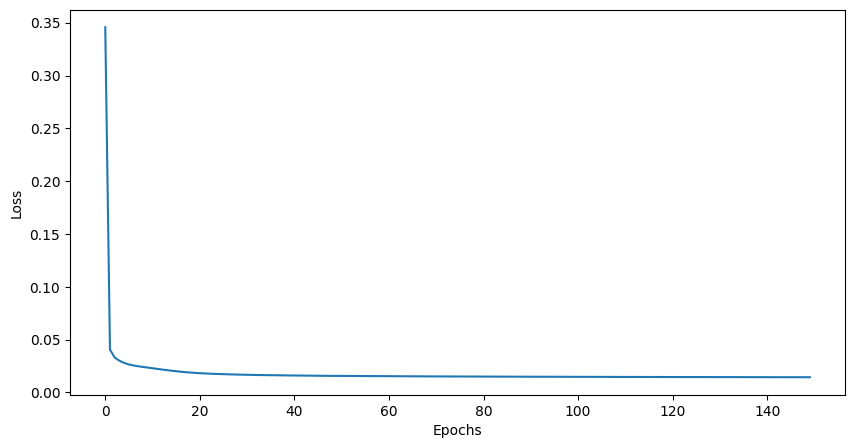

In [152]:
plot_loss(jp_train_loss)
print(min(jp_train_loss))

In [145]:
torch.save(model_joint_pos.state_dict(), f"model/HEBB-joint_pos.pth")
torch.save(jp_train_loss, f"loss/joint_pos.pth")

### Evaluate model

In [153]:
state_dict = torch.load(f"model/HEBB-joint_pos.pth")
model_joint_pos.load_state_dict(state_dict)

<All keys matched successfully>

In [154]:
y_np, pred_np, mu_np, var_np = evaluate_model(model_joint_pos, eva_input, eva_label)


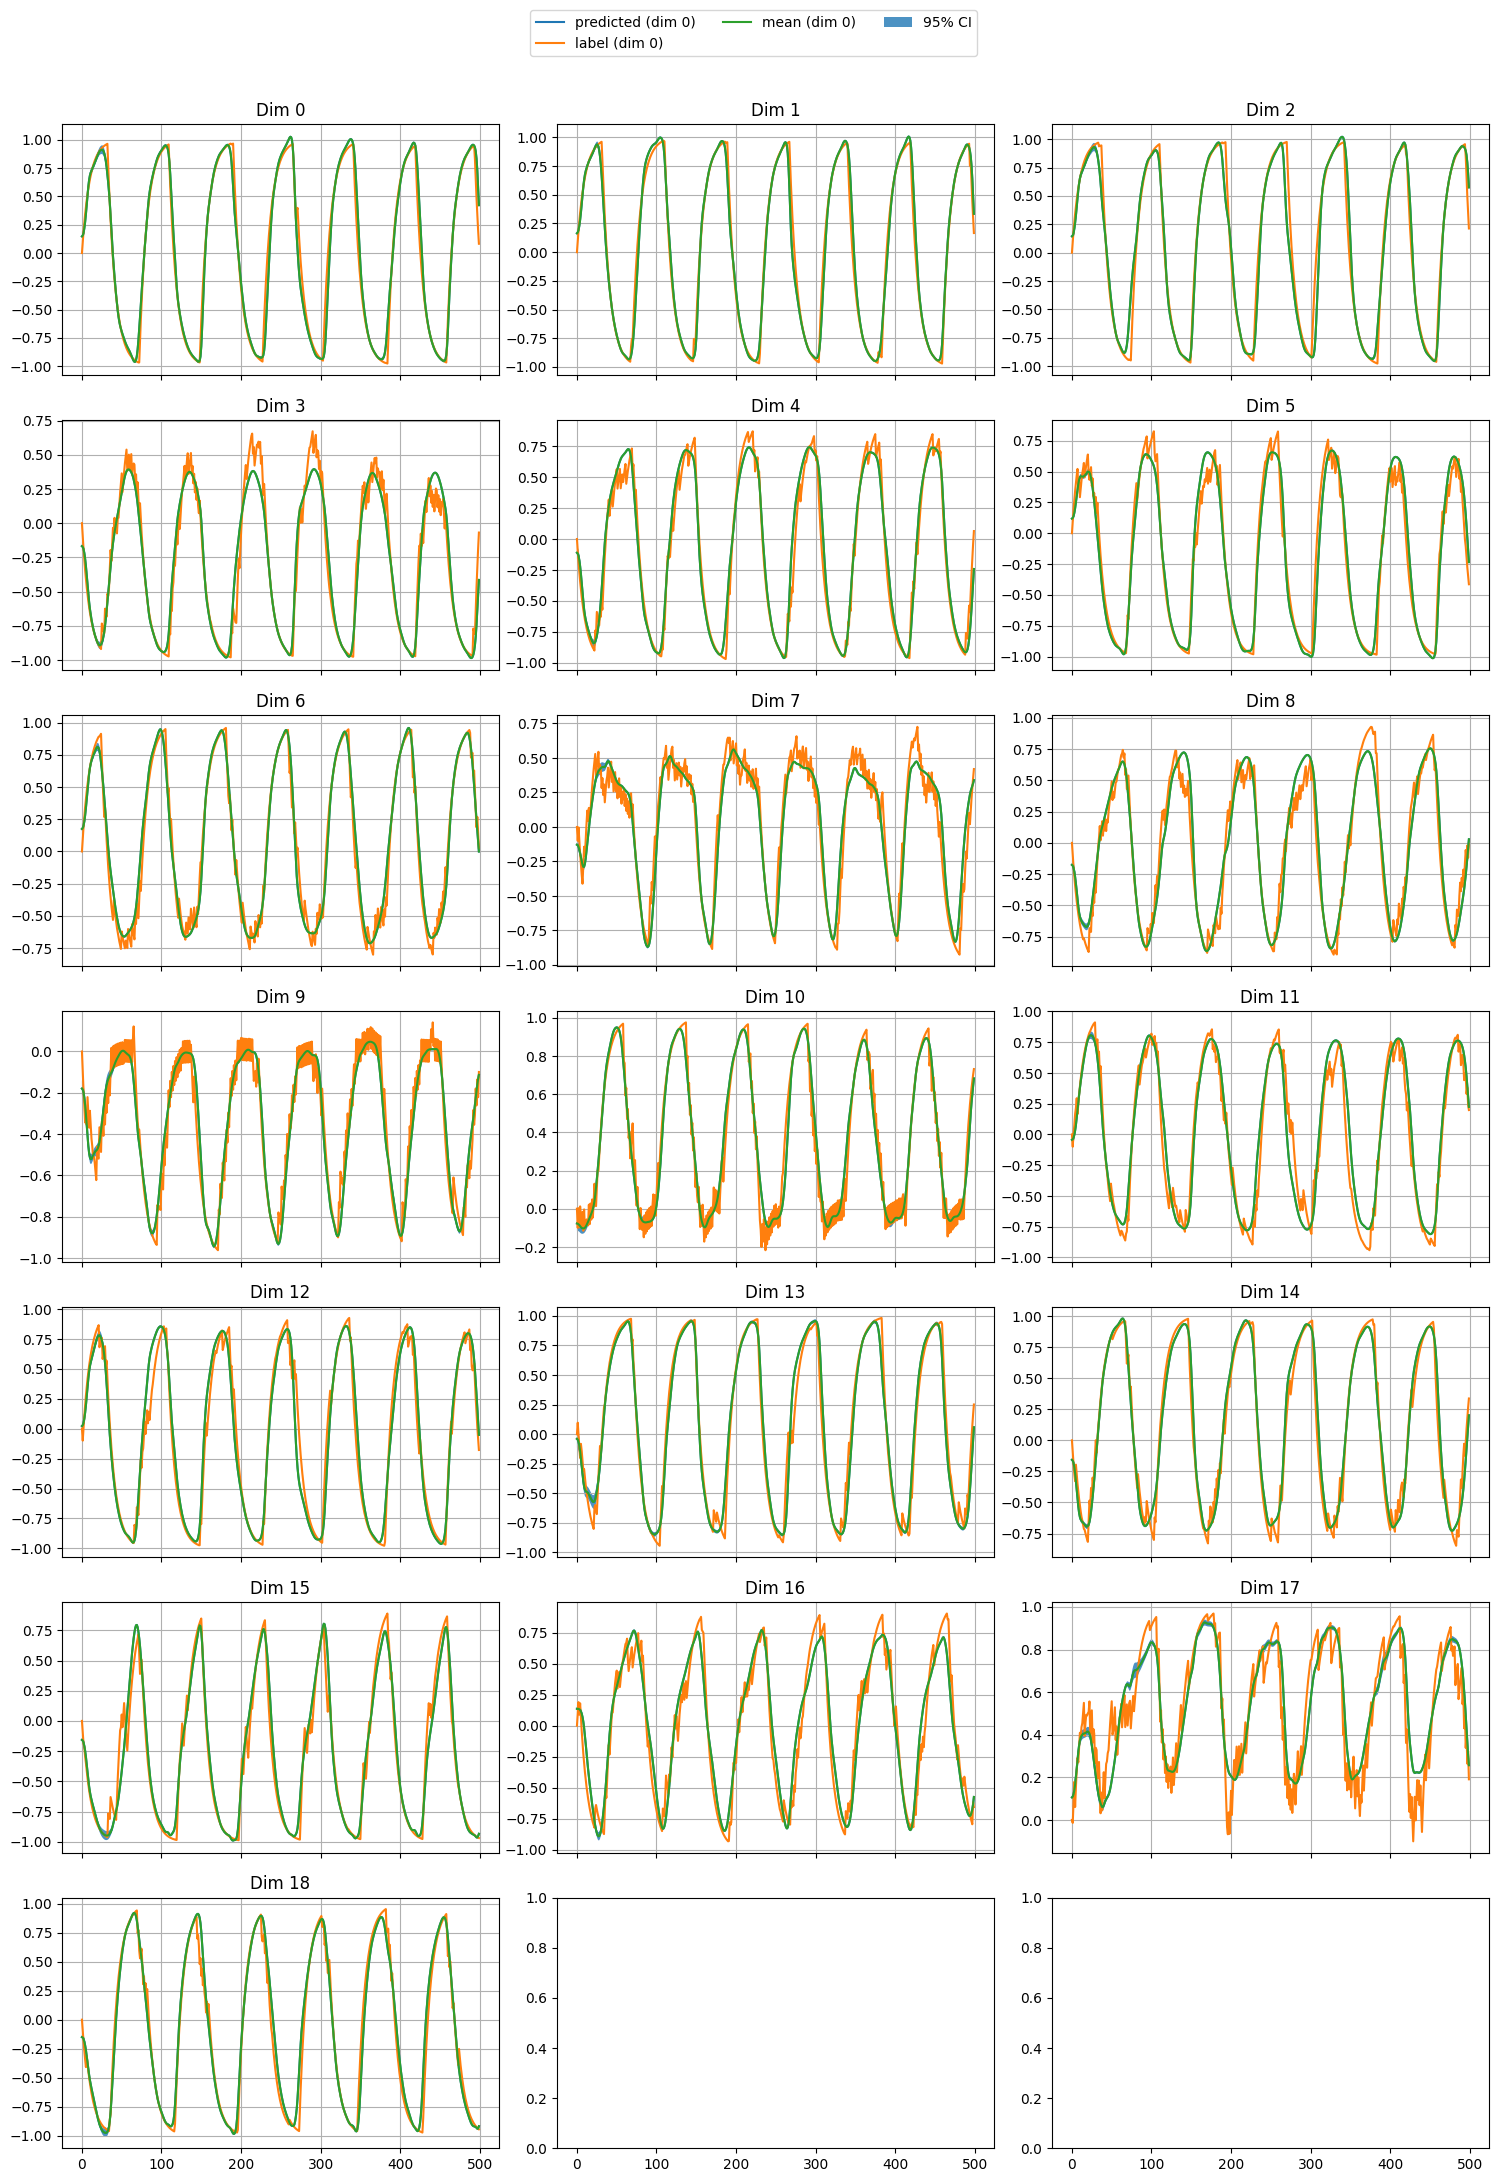

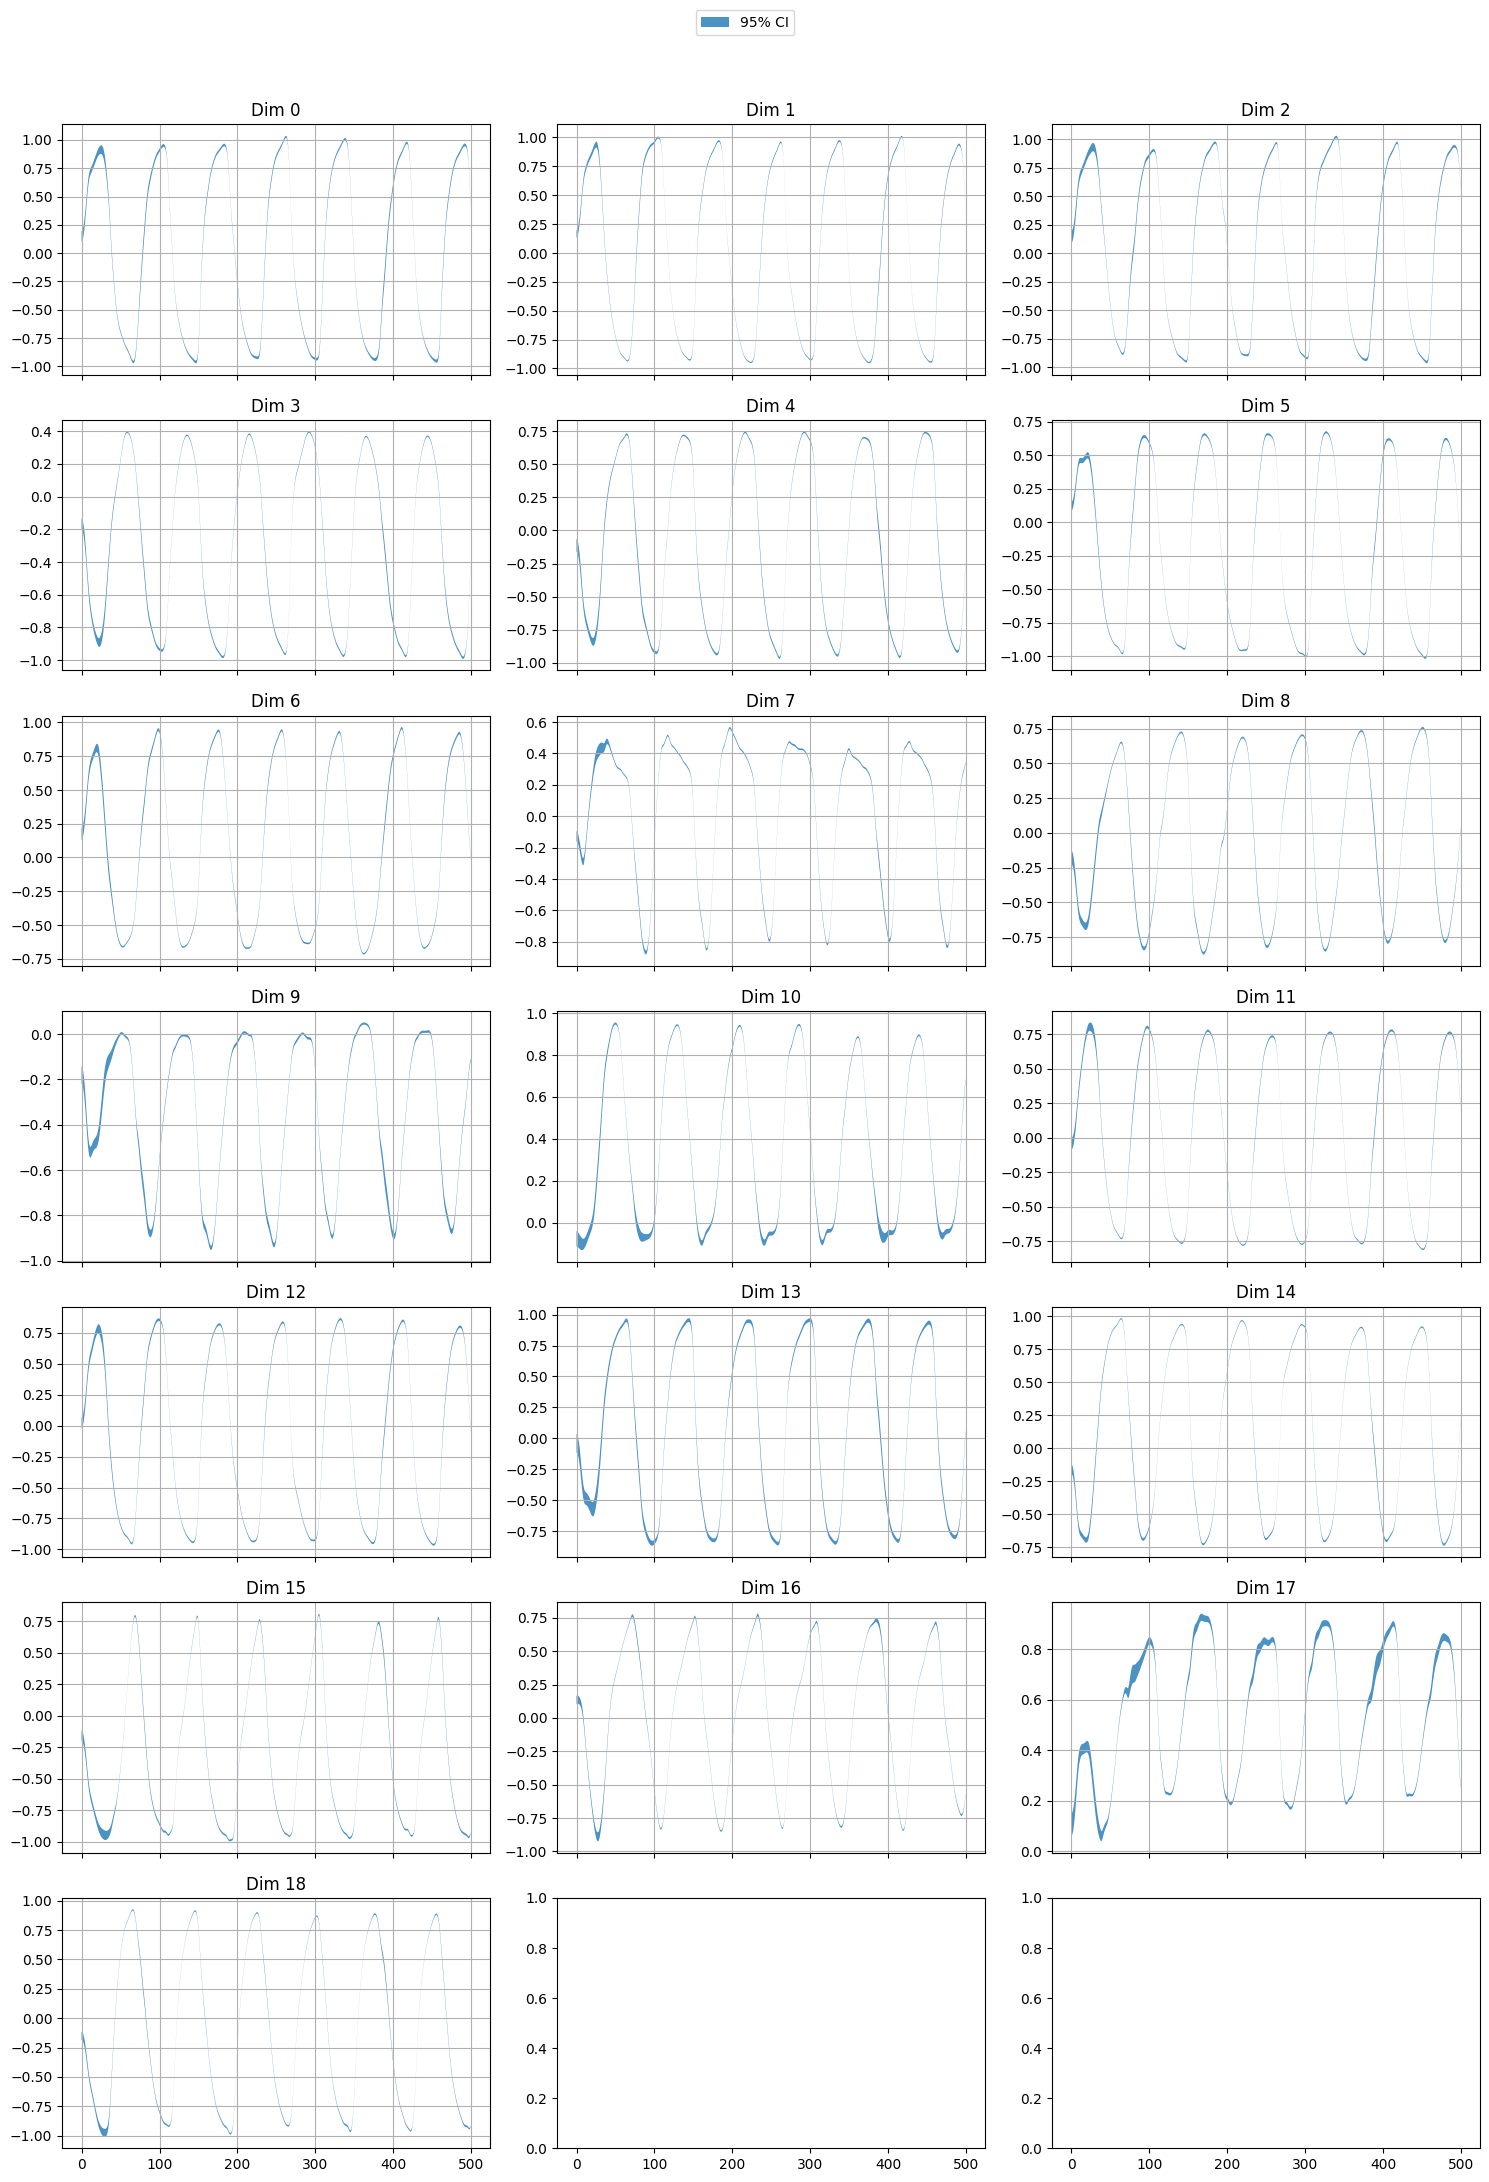

In [155]:
plot_eva_all(y_np, pred_np, mu_np, var_np, dim, cols, rows)
plot_eva_var(y_np, pred_np, mu_np, var_np, dim, cols, rows)

## Joint Vel model

### Train

In [156]:
state_index = torch.arange(19, 38)
state_dim = len(state_index)

train_dataset = TensorDataset(train_x[:,state_index], train_y)
test_dataset = TensorDataset(test_x[:,state_index], test_y)

print("TRAIN : X , Y shape : ",train_x[:,state_index].shape , train_y.shape)
print("TEST : X , Y shape : ",test_x[:,state_index].shape , test_y.shape)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len_train_dataset = len(train_dataset)
len_test_dataset = len(test_dataset)

TRAIN : X , Y shape :  torch.Size([75000, 19]) torch.Size([75000, 19])
TEST : X , Y shape :  torch.Size([0, 19]) torch.Size([0, 19])


In [161]:
batch_size = 128
hidden_dim = 1024
lr = 0.0006423610753393246

model_joint_vel = Predictor(input_dim=state_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(DEVICE)
optimizer_joint_vel = Adam(model_joint_vel.parameters(), lr=lr)

In [ ]:
jv_train_loss =train_model(model_joint_vel,optimizer_joint_vel,epochs,train_loader , test_loader , len_train_dataset , len_test_dataset)


Epoch 1/150 | Train Loss: 0.044390
Epoch 2/150 | Train Loss: 0.011485
Epoch 3/150 | Train Loss: 0.010843
Epoch 4/150 | Train Loss: 0.010647
Epoch 5/150 | Train Loss: 0.010425
Epoch 6/150 | Train Loss: 0.010366
Epoch 7/150 | Train Loss: 0.010272
Epoch 8/150 | Train Loss: 0.010162
Epoch 9/150 | Train Loss: 0.010066
Epoch 10/150 | Train Loss: 0.009958
Epoch 11/150 | Train Loss: 0.009944
Epoch 12/150 | Train Loss: 0.009843
Epoch 13/150 | Train Loss: 0.009833
Epoch 14/150 | Train Loss: 0.009744
Epoch 15/150 | Train Loss: 0.009672
Epoch 16/150 | Train Loss: 0.009646
Epoch 17/150 | Train Loss: 0.009609
Epoch 18/150 | Train Loss: 0.009544
Epoch 19/150 | Train Loss: 0.009549
Epoch 20/150 | Train Loss: 0.009555
Epoch 21/150 | Train Loss: 0.009472
Epoch 22/150 | Train Loss: 0.009463
Epoch 23/150 | Train Loss: 0.009371
Epoch 24/150 | Train Loss: 0.009434
Epoch 25/150 | Train Loss: 0.009338
Epoch 26/150 | Train Loss: 0.009286
Epoch 27/150 | Train Loss: 0.009312
Epoch 28/150 | Train Loss: 0.009264
E

0.007802250227481127


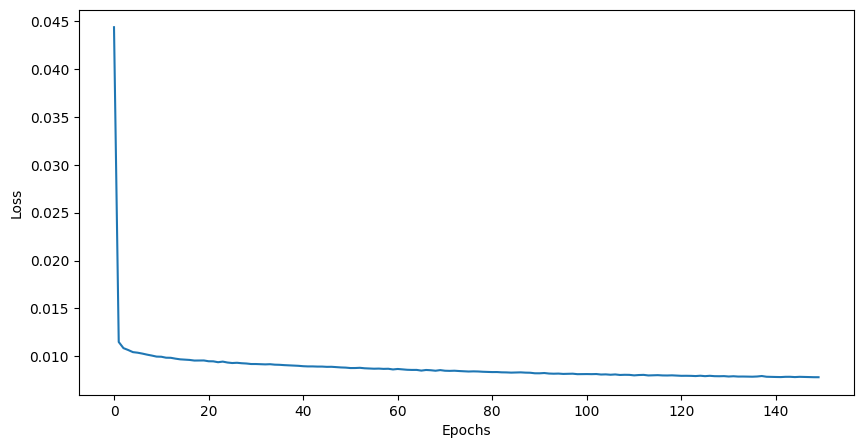

In [164]:
plot_loss(jv_train_loss)
print(min(jv_train_loss))

In [ ]:
torch.save(jv_train_loss, f"loss/joint_vel.pth")
torch.save(model_joint_pos.state_dict(), f"model/HEBB-joint_vel.pth")

### Evaluate

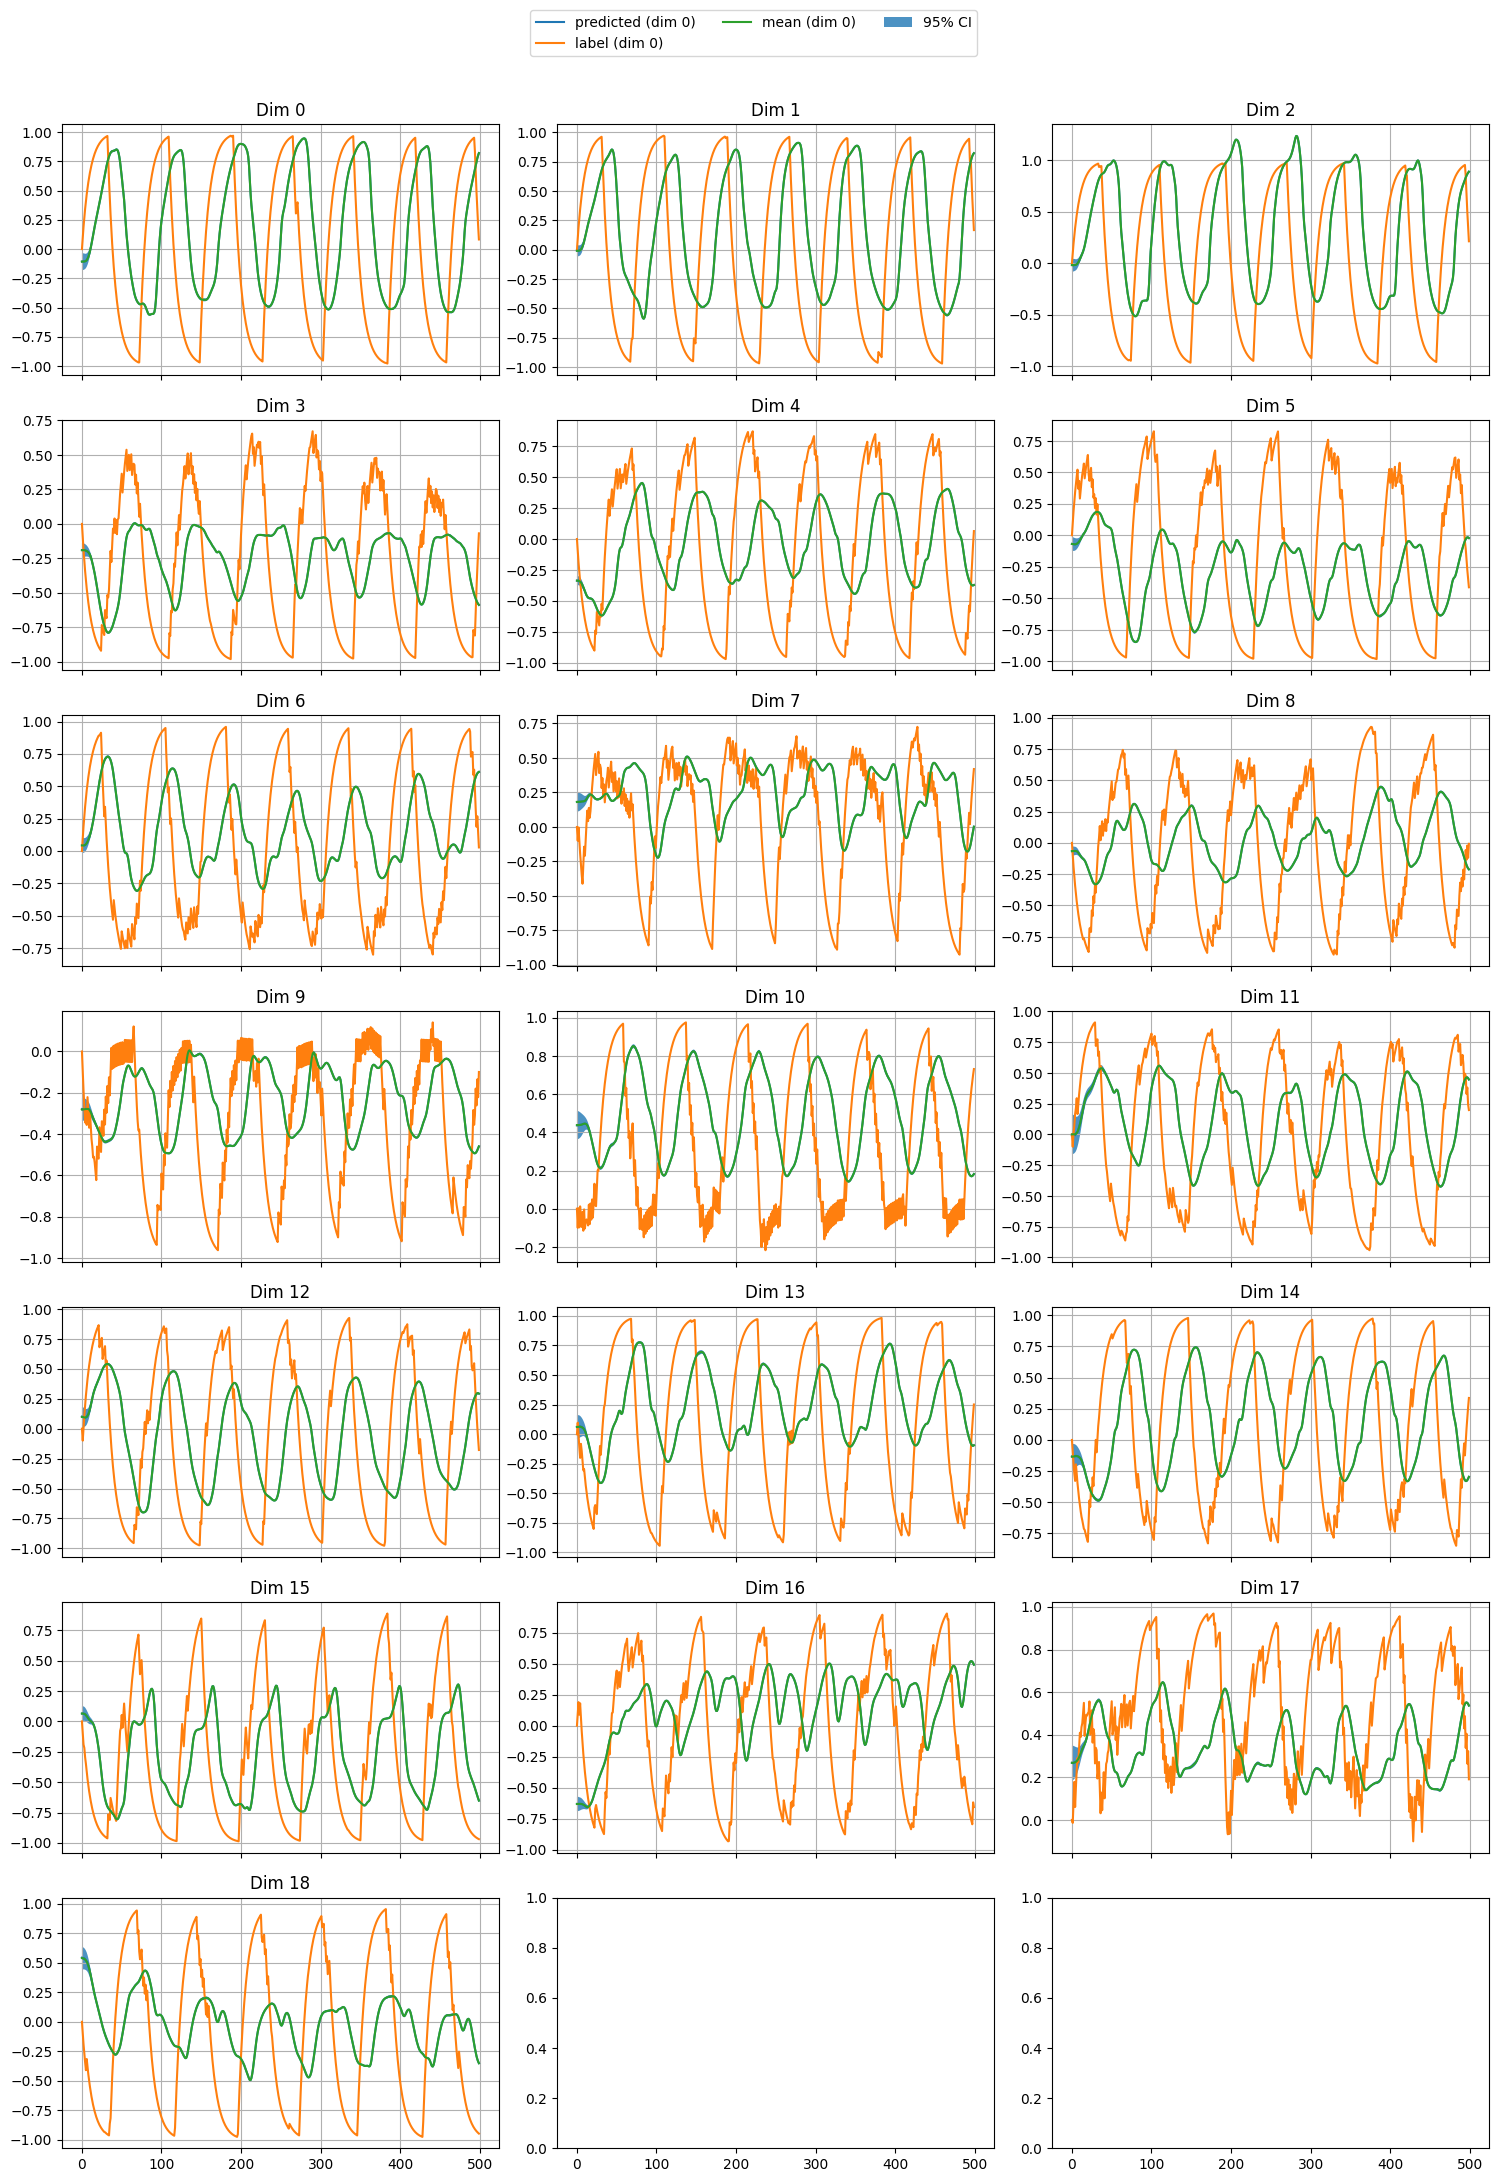

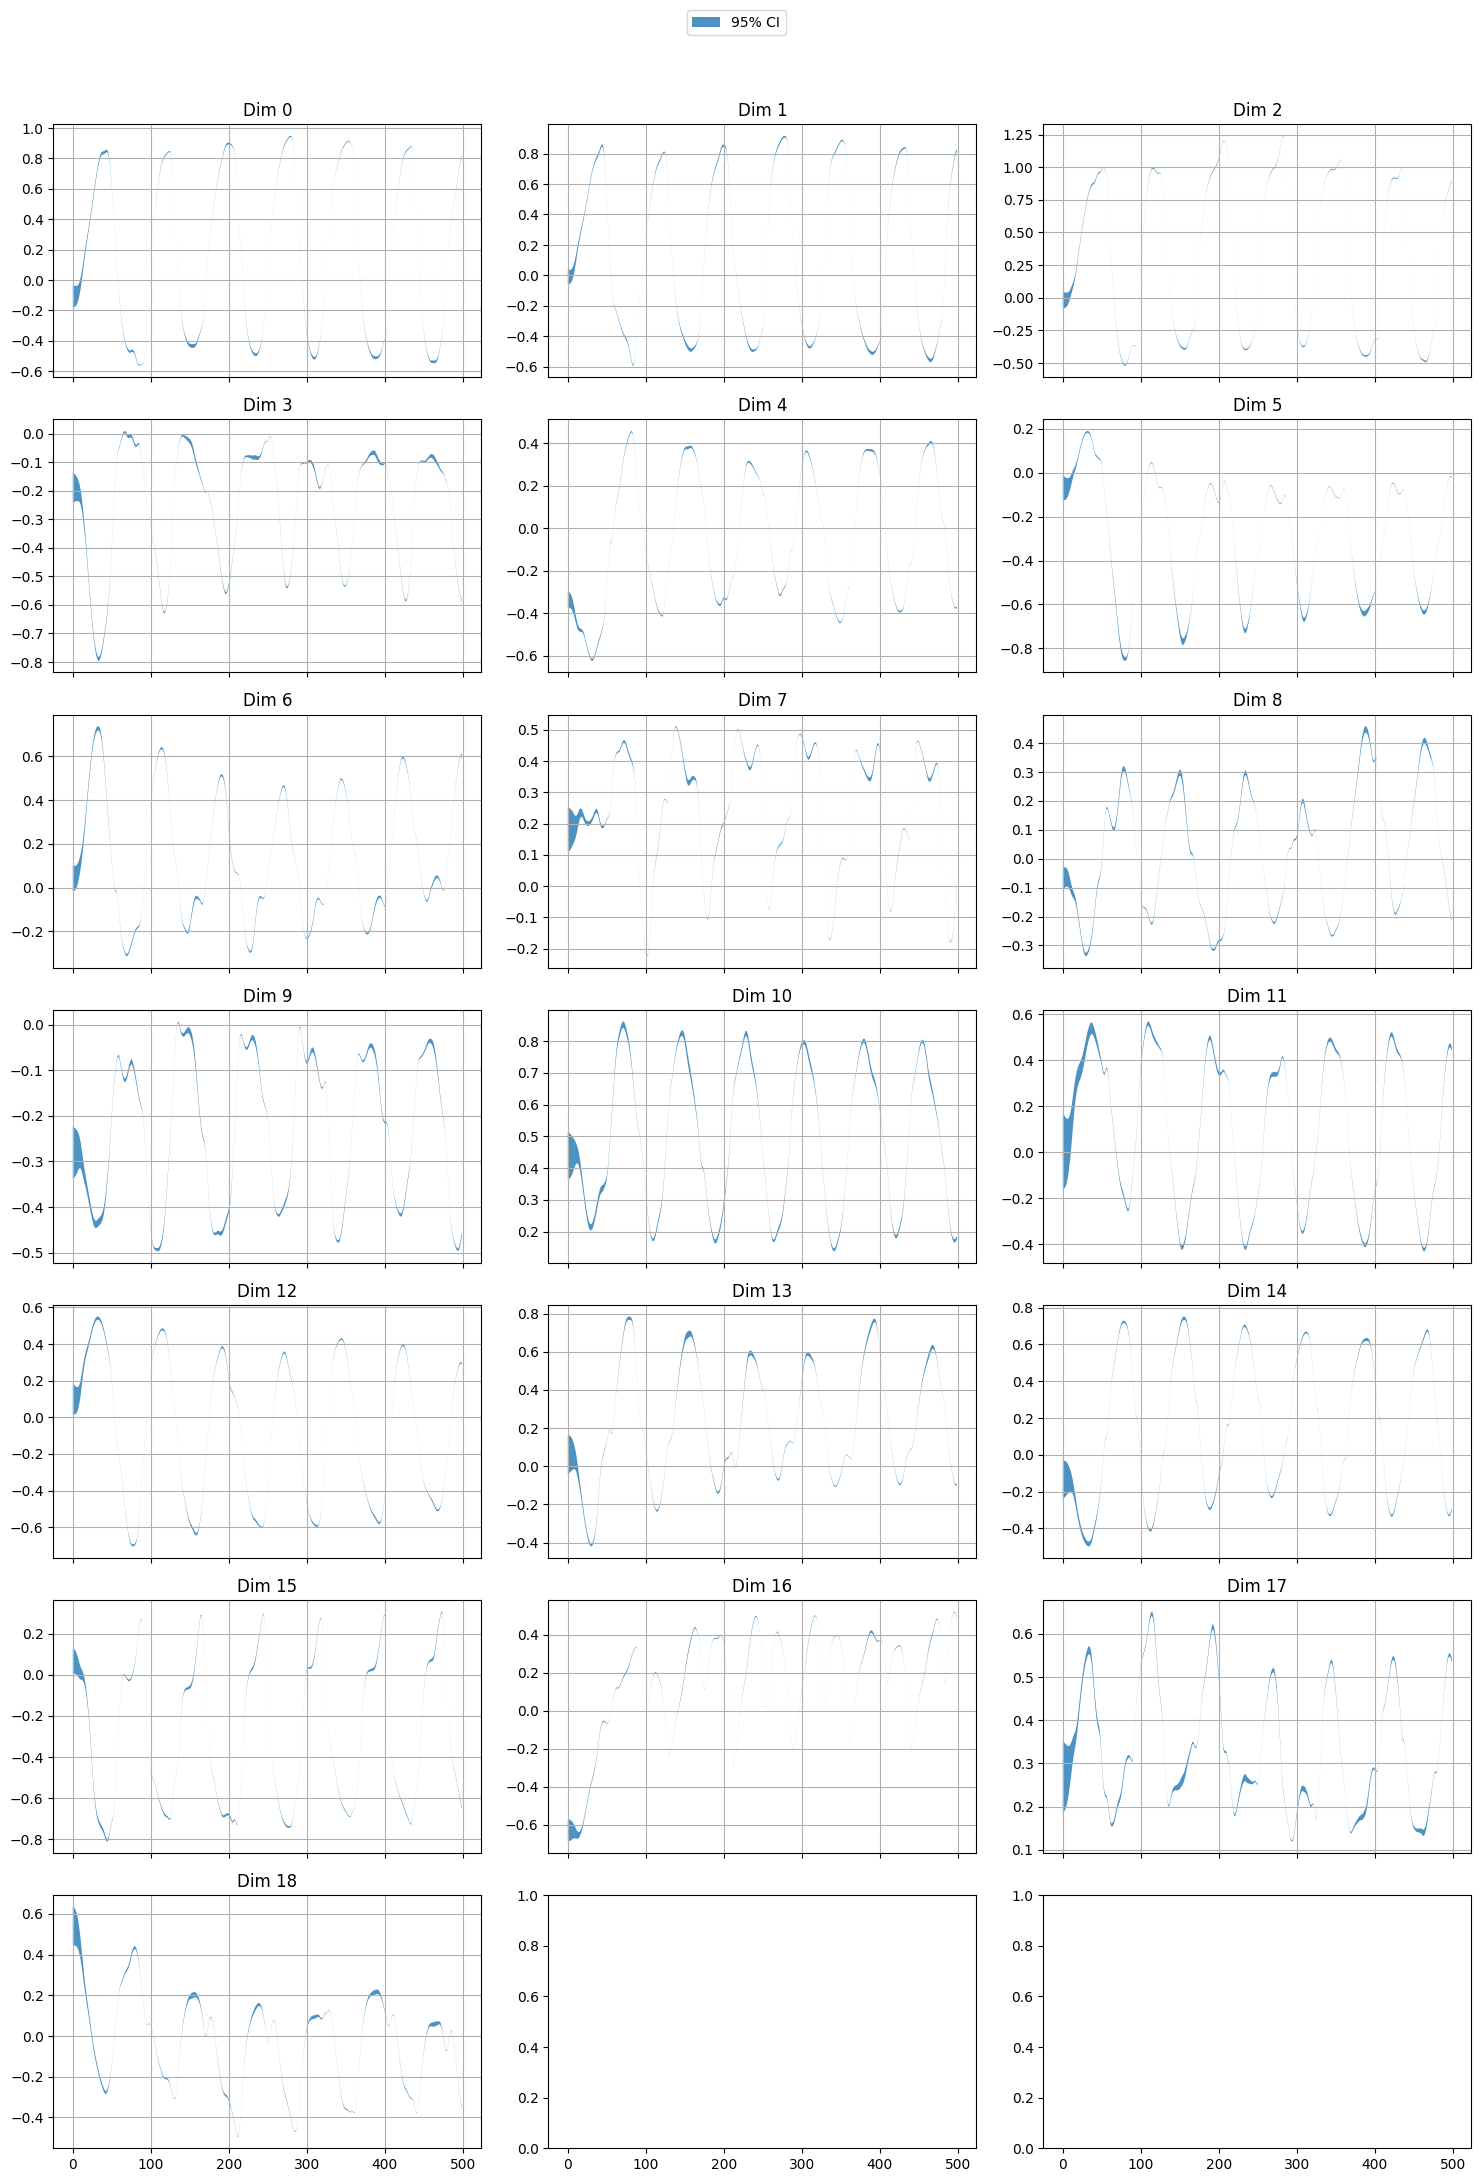

In [165]:
y_np, pred_np, mu_np, var_np = evaluate_model(model_joint_vel, eva_input, eva_label)
plot_eva_all(y_np, pred_np, mu_np, var_np, dim, cols, rows)
plot_eva_var(y_np, pred_np, mu_np, var_np, dim, cols, rows)